In [1]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn geopandas shapely  textblob vaderSentiment  pmdarima
!pip install mlxtend



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.2 MB/s eta 0:00:00


In [2]:
!pip install  optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 7.1 MB/s eta 0:00:00


In [3]:
import optuna
print(optuna.__version__)


4.1.0


In [4]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
###. Step 1: Load the Refined Dataset

import pandas as pd

# Define the file path for the refined dataset
file_path = '/content/drive/MyDrive/refined_dataset.csv'

# Load the refined dataset
refined_dataset = pd.read_csv(file_path)




In [6]:
# Step 2: Perform EDA -statistical summary of a dataset
refined_dataset.describe()


# The total number of observations are 58,539.

# The mean  of rating is  3.70

# median of 4.0 (ratings are skewed toward positive reviews)






,stars_y,review_count,useful,funny
count,58539.000000,58539.000000,58539.000000,58539.000000
mean,3.700354,76.245699,1.146911,0.326159
std,1.316957,85.522564,1.999575,1.120363
min,1.000000,5.000000,0.000000,0.000000
25%,3.000000,23.000000,0.000000,0.000000
50%,4.000000,51.000000,0.000000,0.000000
75%,5.000000,96.000000,2.000000,0.000000
max,5.000000,486.000000,66.000000,57.000000


In [7]:
print("Loaded Refined Dataset:")
display(refined_dataset.tail())

Loaded Refined Dataset:


,text,stars_y,review_count,useful,funny
58534,"We have been going to Japanese Village (""JV"") ...",3,35,2,1
58535,Went Christmas eve as to celebrate holidays on...,2,35,0,0
58536,We came here a couple days ago for dinner. It ...,2,35,2,1
58537,I wouldn't recommend this restaurant. We went ...,1,35,0,0
58538,"I started going to Japanese Village years ago,...",4,35,1,0


In [8]:
print(refined_dataset.columns)


Index(['text', 'stars_y', 'review_count', 'useful', 'funny'], dtype='object')


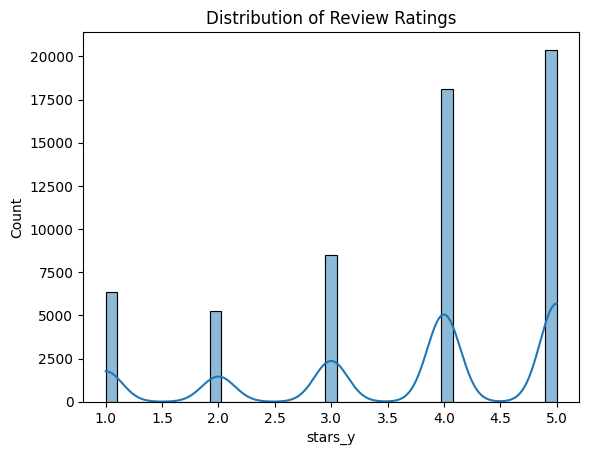

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(refined_dataset['stars_y'], kde=True)
plt.title('Distribution of Review Ratings')
plt.show()


In [10]:
###  project includes a time frame from 2008 to 2021 and factors like being near tourist attractions and the types of cuisine offered.



# Add back the 'date' column if it's missing
if 'date' not in refined_dataset.columns:
    # Load the original dataset to get the 'date' column
    attraction_filtered_review_df = pd.read_csv('/content/drive/MyDrive/attraction_filtered_reviews.csv')

    # Merge the 'date' column back into the refined dataset using 'text' as the key
    refined_dataset = refined_dataset.merge(
        attraction_filtered_review_df[['text', 'date']],
        on='text',
        how='inner'
    )

# Ensure 'date' is in datetime format
refined_dataset['date'] = pd.to_datetime(refined_dataset['date'])



# Define the timeframe for filtering
start_date = '2008-01-01'
end_date = '2021-12-31'

# Filter the dataset for the desired timeframe
filtered_dataset = refined_dataset[
    (refined_dataset['date'] >= start_date) &
    (refined_dataset['date'] <= end_date)
]

print(f"Dataset filtered for reviews between {start_date} and {end_date}.")
print(f"Number of reviews in the filtered dataset: {len(filtered_dataset)}")


Dataset filtered for reviews between 2008-01-01 and 2021-12-31.
Number of reviews in the filtered dataset: 18795


In [11]:
print(filtered_dataset.columns)

Index(['text', 'stars_y', 'review_count', 'useful', 'funny', 'date'], dtype='object')


In [12]:
####. Research Question 1 : What are the predominant sentiments in Yelp reviews for Edmonton restaurants near tourist attractions?
####. Research Question 3: Which cuisines are most popular among highly-rated restaurants located near tourist attractions?



In [13]:
#########.     BERT Sentiment Analysis.     ##########

# I  used transformers library and set up pre-trained BERT model .


from transformers import pipeline

# Initialize BERT sentiment-analysis pipeline




try:
    sentiment_pipeline_bert = pipeline(
        'sentiment-analysis',
        model='distilbert-base-uncased-finetuned-sst-2-english',
        device=0  # Use GPU if available for faster faster computations
    )
except ValueError:
    print("GPU not available. Switching to CPU.")
    sentiment_pipeline_bert = pipeline(
        'sentiment-analysis',
        model='distilbert-base-uncased-finetuned-sst-2-english',
        device=-1  # Use CPU
    )


# maximum token limit is 512 characters

def truncate_text(text, max_length=512):
    return text[:max_length]

# Avoid modifying the original dataset directly
filtered_dataset = filtered_dataset.copy()


# This line shortens all reviews in the text column to 512 characters and saves the results in a new column called text_truncated.
filtered_dataset['text_truncated'] = filtered_dataset['text'].apply(truncate_text)


# Apply BERT sentiment analysis without the 'clean_up_tokenization_spaces' parameter
filtered_dataset['bert_sentiment'] = filtered_dataset['text_truncated'].apply(
    lambda x: sentiment_pipeline_bert(x)[0]['label']
)

print("BERT sentiment analysis complete.")
display(filtered_dataset[['text', 'bert_sentiment']].head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


BERT sentiment analysis complete.


,text,bert_sentiment
0,Came here to print off some documents and was ...,POSITIVE
1,Naked Cyber & Expresso Bar is a 24 hours cyber...,NEGATIVE
2,I visited Naked for the first time this weeken...,NEGATIVE
3,Neat cafe! Delicious sandwiches and sweets wit...,POSITIVE
4,"Naked is a cyber-cafe, one of the first ones t...",POSITIVE


In [14]:
print(filtered_dataset.columns)

Index(['text', 'stars_y', 'review_count', 'useful', 'funny', 'date',
       'text_truncated', 'bert_sentiment'],
      dtype='object')


<ipython-input-15-0d9009386b59>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['cuisine'] = positive_reviews['text'].apply(classify_cuisine)
<ipython-input-15-0d9009386b59>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values, palette='viridis')


Cuisine Popularity Near Tourist Attractions:
cuisine
other         7224
american       959
vegan          883
italian        818
pizzeria       745
indian         684
japanese       577
mexican        567
ethiopian      472
vietnamese     446
chinese        378
french         342
seafood        335
asian          199
korean         131
thai           119
spanish        107
cajun           91
greek           62
lebanese        45
halal           39
turkish         38
persian         27
brazilian       19
kosher           2
Name: count, dtype: int64


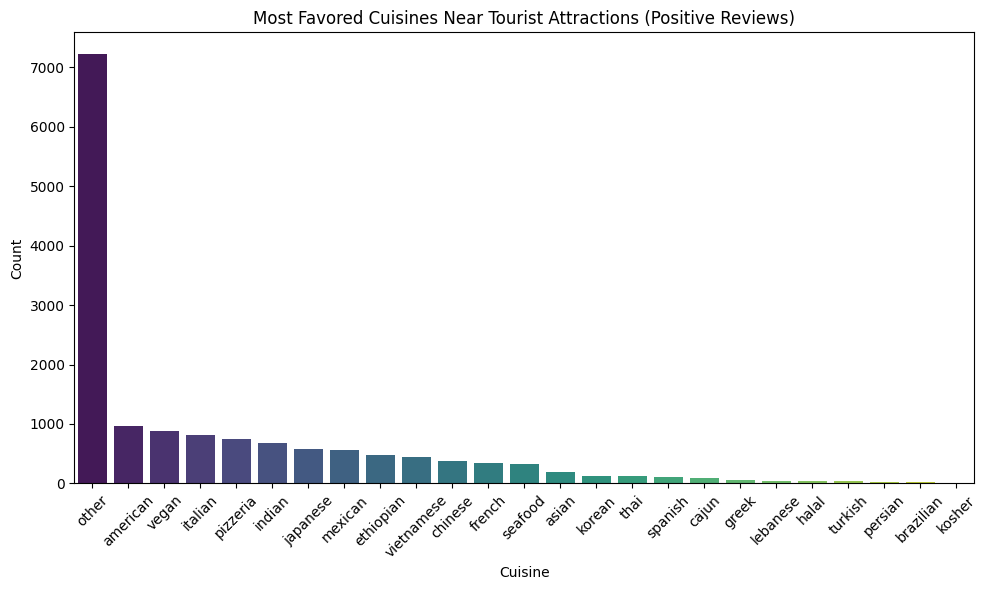

In [15]:
# Research Question 3: Which cuisines are most popular among highly-rated restaurants located near tourist attractions?

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define cuisine categories and keywords
cuisine_keywords = {
    'halal': ['halal', 'middle eastern', 'arabic'],
    'indian': ['indian', 'curry', 'tandoori', 'biryani'],
    'mexican': ['mexican', 'taco', 'burrito', 'quesadilla'],
    'vegan': ['vegan', 'vegetarian', 'plant-based', 'no meat'],
    'persian': ['persian', 'kebab', 'ghormeh sabzi'],
    'pizzeria': ['pizza', 'pizzeria', 'calzone'],
    'italian': ['italian', 'pasta', 'lasagna', 'risotto'],
    'japanese': ['japanese', 'sushi', 'ramen', 'tempura'],
    'chinese': ['chinese', 'noodles', 'dim sum', 'wontons'],
    'thai': ['thai', 'pad thai', 'curry', 'tom yum'],
    'french': ['french', 'crepes', 'bistro', 'ratatouille'],
    'korean': ['korean', 'kimchi', 'bulgogi'],
    'greek': ['greek', 'gyros', 'moussaka'],
    'cajun': ['cajun', 'creole', 'gumbo'],
    'turkish': ['turkish', 'kebab', 'baklava'],
    'kosher': ['kosher', 'koshert', 'matzo', 'challah'],
    'seafood': ['seafood', 'lobster', 'shrimp', 'oyster'],
    'lebanese': ['lebanese', 'hummus', 'falafel', 'tabbouleh'],
    'spanish': ['spanish', 'paella', 'tapas'],
    'vietnamese': ['vietnamese', 'pho', 'banh mi'],
    'brazilian': ['brazilian', 'churrasco', 'feijoada'],
    'ethiopian': ['ethiopian', 'injera', 'wat'],
    'american': ['american', 'burger', 'steak', 'bbq', 'fried chicken', 'hot dog'],
    'japanese': ['japanese', 'sushi', 'ramen', 'tempura', 'sashimi', 'teriyaki'],
    'italian': ['italian', 'pasta', 'lasagna', 'risotto', 'spaghetti', 'bruschetta'],
    'indian': ['indian', 'curry', 'tandoori', 'biryani', 'naan', 'masala'],
    'asian': ['bubble tea', 'boba', 'green tea', 'matcha'],


    'other': ['restaurant','dine']  # Catch-all category
}

# Function to classify cuisines based on keywords
def classify_cuisine(text):
    text_lower = str(text).lower()
    for cuisine, keywords in cuisine_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            return cuisine
    return 'other'

# Load the dataset
file_path = '/content/drive/MyDrive/refined_dataset.csv'
dataset = pd.read_csv(file_path)

# Filter dataset for positive reviews
positive_reviews = filtered_dataset[filtered_dataset['bert_sentiment'] == 'POSITIVE']


# Apply cuisine classification
positive_reviews['cuisine'] = positive_reviews['text'].apply(classify_cuisine)

# Count the frequency of each cuisine
cuisine_counts = positive_reviews['cuisine'].value_counts()

# Display results
print("Cuisine Popularity Near Tourist Attractions:")
print(cuisine_counts)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values, palette='viridis')
plt.title('Most Favored Cuisines Near Tourist Attractions (Positive Reviews)')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
print(positive_reviews[positive_reviews['cuisine'] == 'other']['text'].head(20))

0     Came here to print off some documents and was ...
3     Neat cafe! Delicious sandwiches and sweets wit...
7     When searching for open mic night in Edmonton,...
9     So I recently got to visit this place. It's a ...
10    Cool space! They have computers and a stage an...
12    Great place for all not just the techies  we l...
14    I didnt know this place was just beside of the...
17    I love Breadland - it's one of those places wh...
18    Love the bread from here.  They have a nice va...
19    This is not your supermarket type bread store....
20    Having only visited this location once, I have...
22    Yum! Fresh! Really enjoy. Local is a plus. Doe...
23    This is the best bread bakery! They have so ma...
24    This bakery is new to Oliver Square area, and ...
25    I love me some pastries and bread. All organic...
26    I like their bread and their offerings of spel...
28    A couple weeks ago I noticed this little baker...
29    Amazing sourdough baked goods made with or

In [17]:
#####.  VADER Sentiment Analysis #######

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



#This object will calculate sentiment scores for each review in your dataset.
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()



####The compound score is the overall sentiment score for a piece of text

# Apply VADER sentiment analysis
filtered_dataset['vader_compound'] = filtered_dataset['text'].apply(
    lambda x: analyzer.polarity_scores(x)['compound'] if isinstance(x, str) else None
)

# Convert VADER compound scores to sentiment labels


###Range
#Positive Sentiment: Compound ≥ 0.05.
#Neutral Sentiment: Compound > -0.05 and < 0.05.
#Negative Sentiment: Compound ≤ -0.05.


filtered_dataset['vader_sentiment'] = filtered_dataset['vader_compound'].apply(
    lambda x: 'POSITIVE' if x >= 0.05 else ('NEGATIVE' if x <= -0.05 else 'NEUTRAL') if x is not None else None

)


print("VADER sentiment analysis complete.")
display(filtered_dataset[['text', 'vader_compound', 'vader_sentiment']].tail())





VADER sentiment analysis complete.


,text,vader_compound,vader_sentiment
18841,When it comes to Ramen in Edmonton. This is y...,0.9925,POSITIVE
18843,Great Ramen.\nService was asking me to take my...,0.7645,POSITIVE
18844,"Great flavour to the Ramen dishes, and the ser...",0.8750,POSITIVE
18845,My husband and I do an instagram date on weeke...,0.9615,POSITIVE
18846,This place is impressively focused. They don't...,0.8038,POSITIVE


In [18]:
#  TextBlob uses a lexicon-based approach with a polarity function that outputs values from -1 to 1
 # where -1 is negative, 1 is positive, and 0 is neutral.


from textblob import TextBlob

# Apply TextBlob sentiment analysis
filtered_dataset['textblob_polarity'] = filtered_dataset['text'].apply(
    lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None
)

# Convert TextBlob polarity scores to sentiment labels
filtered_dataset['textblob_sentiment'] = filtered_dataset['textblob_polarity'].apply(
    lambda x: 'POSITIVE' if x > 0 else ('NEGATIVE' if x < 0 else 'NEUTRAL') if x is not None else None
)

#The polarity scores are converted into sentiment labels:
#Positive Sentiment: Polarity > 0.
#Negative Sentiment: Polarity < 0.
#Neutral Sentiment: Polarity = 0.

print("TextBlob sentiment analysis complete.")
display(filtered_dataset[['text', 'textblob_polarity', 'textblob_sentiment']].head())

TextBlob sentiment analysis complete.


,text,textblob_polarity,textblob_sentiment
0,Came here to print off some documents and was ...,0.316667,POSITIVE
1,Naked Cyber & Expresso Bar is a 24 hours cyber...,0.229545,POSITIVE
2,I visited Naked for the first time this weeken...,0.274362,POSITIVE
3,Neat cafe! Delicious sandwiches and sweets wit...,0.467857,POSITIVE
4,"Naked is a cyber-cafe, one of the first ones t...",0.114706,POSITIVE


In [19]:
####.    classification_report, confusion_matrix, accuracy_score. ####



import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Define True Sentiment Labels (Ground Truth) Based on 'stars_y'
def determine_sentiment(stars):
    if stars >= 4:
        return 'POSITIVE'
    elif stars <= 2:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

# Add the true sentiment labels to the dataset
filtered_dataset['true_sentiment'] = filtered_dataset['stars_y'].apply(determine_sentiment)
y_true = filtered_dataset['true_sentiment'].values

# Step 2: Fetch Predictions from Models
textblob_pred = filtered_dataset['textblob_sentiment'].values
vader_pred = filtered_dataset['vader_sentiment'].values
bert_pred = filtered_dataset['bert_sentiment'].values


In [20]:
# Step 3: Evaluation Metrics for Each Model
# TextBlob Metrics
print("TextBlob Metrics:")
print(classification_report(y_true, textblob_pred))
print(confusion_matrix(y_true, textblob_pred))


# Precision measures how many of the predicted examples for a class are correct.(What the model predicted.)

#  Recall measures how many of the actual instances of a class are correctly identified.(What actually exists in the data.)

#  The F1-score combines precision and recall into a single metric, balancing false positives and false negatives.

#  Support is the number of actual instances for each class.

TextBlob Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.60      0.36      0.45      1640
     NEUTRAL       0.03      0.00      0.00      2075
    POSITIVE       0.83      0.98      0.90     15080

    accuracy                           0.82     18795
   macro avg       0.49      0.45      0.45     18795
weighted avg       0.73      0.82      0.76     18795

[[  597    14  1029]
 [  166     2  1907]
 [  232    47 14801]]


In [21]:
# VADER Metrics
print("\nVADER Metrics:")
print(classification_report(y_true, vader_pred))
print(confusion_matrix(y_true, vader_pred))


VADER Metrics:
              precision    recall  f1-score   support

    NEGATIVE       0.62      0.38      0.47      1640
     NEUTRAL       0.16      0.01      0.02      2075
    POSITIVE       0.84      0.98      0.91     15080

    accuracy                           0.82     18795
   macro avg       0.54      0.46      0.47     18795
weighted avg       0.75      0.82      0.77     18795

[[  626    49   965]
 [  194    24  1857]
 [  182    81 14817]]


In [22]:

# BERT Metrics
print("\nBERT Metrics:")
print(classification_report(y_true, bert_pred))
print(confusion_matrix(y_true, bert_pred))

# Negative Sentiments: Low precision (40%) but high recall (85%), meaning it correctly identifies most negative reviews but also misclassifies many as negative.


BERT Metrics:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    NEGATIVE       0.40      0.85      0.55      1640
     NEUTRAL       0.00      0.00      0.00      2075
    POSITIVE       0.91      0.92      0.92     15080

    accuracy                           0.82     18795
   macro avg       0.44      0.59      0.49     18795
weighted avg       0.77      0.82      0.78     18795

[[ 1401     0   239]
 [  933     0  1142]
 [ 1152     0 13928]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# Step 4: Accuracy Comparison Across Models
models = ['TextBlob', 'VADER', 'BERT']
accuracies = [
    accuracy_score(y_true, textblob_pred),
    accuracy_score(y_true, vader_pred),
    accuracy_score(y_true, bert_pred)
]

print("\nAccuracy Comparison:")
for model, accuracy in zip(models, accuracies):
    print(f"{model}: {accuracy:.2f}")



Accuracy Comparison:
TextBlob: 0.82
VADER: 0.82
BERT: 0.82


In [24]:
# Step 5: Error Analysis with Random Sampling
# Create DataFrame for error analysis
error_analysis_df = filtered_dataset[['text', 'true_sentiment']].copy()
error_analysis_df['bert_sentiment'] = bert_pred
error_analysis_df['vader_sentiment'] = vader_pred
error_analysis_df['textblob_sentiment'] = textblob_pred

# Identify cases
correctly_classified_by_bert = error_analysis_df[
    (error_analysis_df['true_sentiment'] == error_analysis_df['bert_sentiment']) &
    ((error_analysis_df['true_sentiment'] != error_analysis_df['vader_sentiment']) |
     (error_analysis_df['true_sentiment'] != error_analysis_df['textblob_sentiment']))
]

misclassified_by_bert = error_analysis_df[
    (error_analysis_df['true_sentiment'] != error_analysis_df['bert_sentiment']) &
    (error_analysis_df['true_sentiment'] == error_analysis_df['vader_sentiment']) &
    (error_analysis_df['true_sentiment'] == error_analysis_df['textblob_sentiment'])
]

# Sample random examples
sample_size = 20  # Adjust sample size as needed
sample_correct_by_bert = correctly_classified_by_bert.sample(n=min(sample_size, len(correctly_classified_by_bert)), random_state=42)
sample_misclassified_by_bert = misclassified_by_bert.sample(n=min(sample_size, len(misclassified_by_bert)), random_state=42)

# Display samples
print("\nSampled Reviews Correctly Classified by BERT but Misclassified by Others:")
sample_correct_by_bert[['text', 'true_sentiment', 'bert_sentiment', 'vader_sentiment', 'textblob_sentiment']]

print("\nSampled Reviews Misclassified by BERT but Correctly Classified by Others:")
sample_misclassified_by_bert[['text', 'true_sentiment', 'bert_sentiment', 'vader_sentiment', 'textblob_sentiment']]



########.      bert struggles.  ######

# Over-sensitivity to negative words

# BERT is designed to understand complex language, so it might not handle simple, direct positivity

# Complex decision-making: BERT analyzes the context deeply. Sometimes, this overthinking leads to errors in straightforward cases


Sampled Reviews Correctly Classified by BERT but Misclassified by Others:

Sampled Reviews Misclassified by BERT but Correctly Classified by Others:


,text,true_sentiment,bert_sentiment,vader_sentiment,textblob_sentiment
12703,So there's about 3 designated parking stalls d...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
9562,"Great Tasty Food, Nice people! Cheap prices f...",POSITIVE,NEGATIVE,POSITIVE,POSITIVE
17702,Sorrentino's and the Sorrentino's group are a ...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
1495,"Rarely would I say, ""Hey, let's go out for Chi...",POSITIVE,NEGATIVE,POSITIVE,POSITIVE
10455,"It's hard to find good Mexican food, and Tres ...",POSITIVE,NEGATIVE,POSITIVE,POSITIVE
6251,I make no secret that the coffee monkey on my ...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
16888,First time at OEB on this crazy freezing morni...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
13501,"Indeed, it was one of our favorite restaurants...",POSITIVE,NEGATIVE,POSITIVE,POSITIVE
3889,Items Selected:\nNibbles Board - Rabbit Rillet...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE
6965,The need for good pho brought me back to Tau B...,POSITIVE,NEGATIVE,POSITIVE,POSITIVE


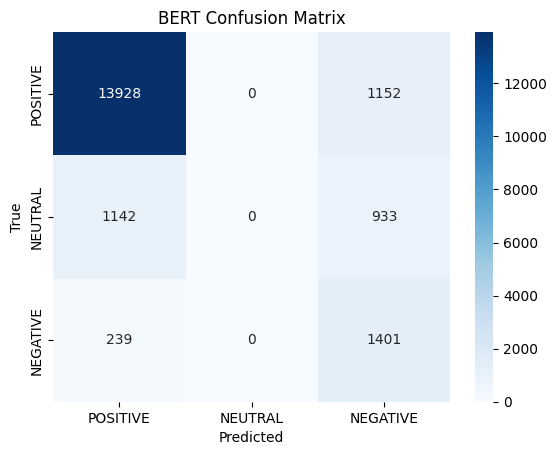

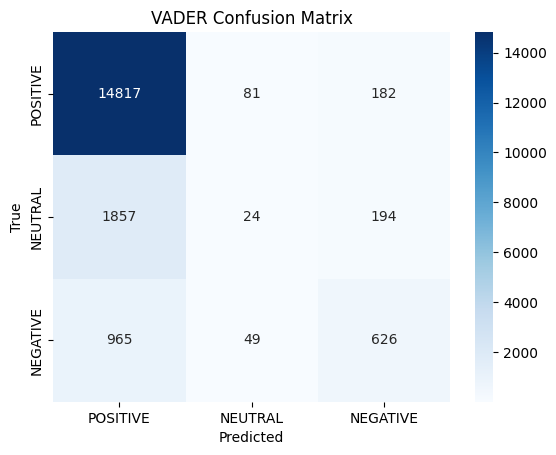

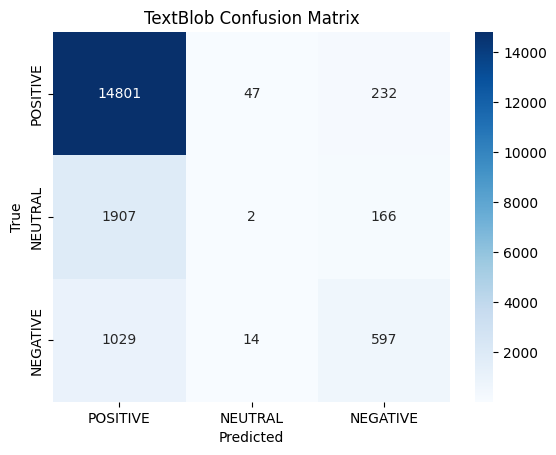

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_true, bert_pred, "BERT Confusion Matrix")
plot_confusion_matrix(y_true, vader_pred, "VADER Confusion Matrix")
plot_confusion_matrix(y_true, textblob_pred, "TextBlob Confusion Matrix")



#BERT: Best at handling negative reviews but completely fails to predict neutral reviews.

#VADER: Excellent for positive reviews but struggles with neutral and negative reviews.

#TextBlob: Also strong for positive reviews but similar weaknesses as VADER."

In [26]:
### Research question 2- How does the overall sentiment trend change over time for restaurants near touristic areas , and what are the projected future trends?

In [27]:
import pandas as pd


#  Convert 'date' column to datetime format and create a new 'year' column

filtered_dataset['date'] = pd.to_datetime(filtered_dataset['date'])
filtered_dataset['year'] = filtered_dataset['date'].dt.year


# Copy sentiment scores from 'vader_compound' column to a new 'sentiment_score'
filtered_dataset['sentiment_score'] = filtered_dataset['vader_compound']

# Calculate the average sentiment score for each year
yearly_sentiments = filtered_dataset.groupby('year')['sentiment_score'].mean()



# Step 3: Define External Events
external_events = {
    2010: "Economic Downturn",
    2013: "Tourist Spike (Local Event)",
    2020: "COVID-19 Pandemic",
}

# Step 4: Add Events to the Aggregated Sentiment Data
# Reset index to convert the series into a DataFrame
yearly_sentiments_df = yearly_sentiments.reset_index()

# Map external events to the year column
yearly_sentiments_df['event'] = yearly_sentiments_df['year'].map(external_events).fillna("")

# Step 5: Display the Resulting DataFrame
yearly_sentiments_df

,year,sentiment_score,event
0,2008,0.900133,
1,2009,0.889375,
2,2010,0.833238,Economic Downturn
3,2011,0.838060,
4,2012,0.828190,
5,2013,0.842449,Tourist Spike (Local Event)
6,2014,0.837658,
7,2015,0.818846,
8,2016,0.799388,
9,2017,0.805248,


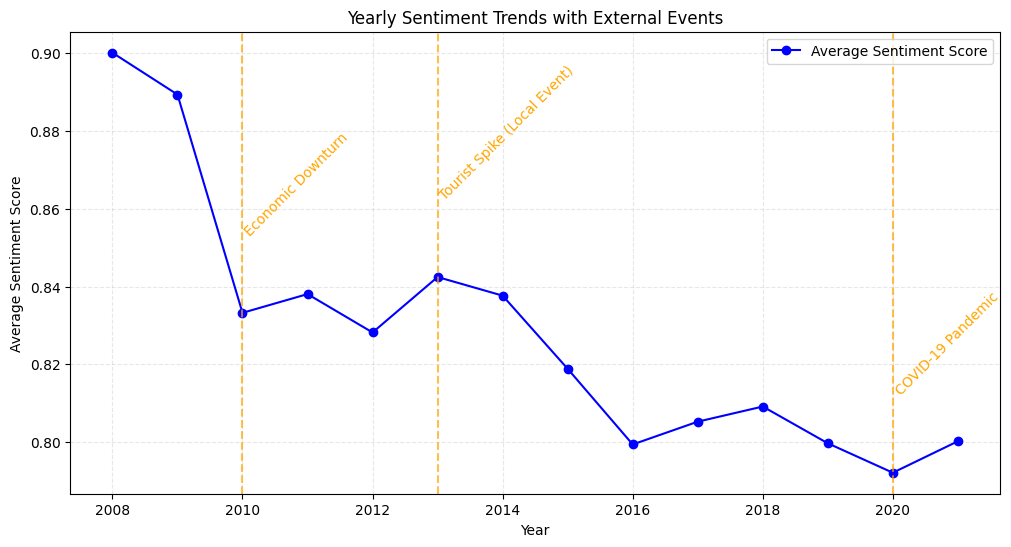

In [28]:
# The plot shows yearly sentiment trends with external events



import matplotlib.pyplot as plt

# Plot sentiment trends
plt.figure(figsize=(12, 6))


# plt.plot() function,creates the line graph for sentiment scores.
plt.plot(yearly_sentiments_df['year'], yearly_sentiments_df['sentiment_score'], marker='o', label='Average Sentiment Score', color='blue')



# Annotate external events
for index, row in yearly_sentiments_df.iterrows():
    if row['event']:  # Only annotate years with events
        plt.axvline(x=row['year'], color='orange', linestyle='--', alpha=0.7)
        plt.text(row['year'], row['sentiment_score'] + 0.02, row['event'], rotation=45, color='orange', fontsize=10)

# Enhance plot appearance
plt.title("Yearly Sentiment Trends with External Events")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.show()

In [29]:
# Set 'year' as the index and ensure it's in datetime format for ARIMA
yearly_sentiments_df['year'] = pd.to_datetime(yearly_sentiments_df['year'], format='%Y')
sentiment_trend = yearly_sentiments_df.set_index('year')['sentiment_score']


In [30]:

#In order to find out the future trend, I used ARIMA, SARIMA, and Prophet and compared the performance.



In [31]:
# When the mean, variance, and seasonality (or autocorrelation structure) of a time series remain constant over time, the data is said to be stationariy.


 ##########     ARIMA model #######



#.    Data should be stationarity to use ARIMA effectively.

# We use the ADF (Augmented Dickey-Fuller) test to  make sure  that the dataset is stationarity.

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Perform the Augmented Dickey-Fuller (ADF) test for stationariy
adf_test = adfuller(sentiment_trend)

# ADF test results
print(f"ADF Statistic: {adf_test[0]:.4f}")
print(f"p-value: {adf_test[1]:.4f}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"\t{key}: {value:.4f}")

if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary. Consider differencing.")

# ADF Statistic NUMBER IS  (-5.4272) is less than critical value
# p-value (0.0000) is less than the common alpha level (0.05) so We reject the null hypothesis of non-stationarity.so we conclus that the dataset is stationariy



ADF Statistic: -5.4272
p-value: 0.0000
Critical Values:
	1%: -4.6652
	5%: -3.3672
	10%: -2.8030
The data is stationary.


In [32]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define and fit ARIMA model

# ARIMA uses (p, d, q) parameters:
#  p=1: Uses 1 past value to predict the next.
#  d=1: A single differencing step is applied to achieve stationarity in the data.
#  q=1: (The moving average component ) Uses 1 past error to improve predictions.



arima_model = ARIMA(sentiment_trend, order=(1, 1, 1))  # Adjust (p, d, q) parameters as needed
arima_result = arima_model.fit()

# Forecast for the next 5 years

# get_forecast(steps=5) function

forecast_arima = arima_result.get_forecast(steps=5)
forecast_mean = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()

# Calculate error metrics

# MAE measures the average absolute difference between predicted and actual values.
mae = mean_absolute_error(sentiment_trend, arima_result.fittedvalues)

mse = mean_squared_error(sentiment_trend, arima_result.fittedvalues)
print(f"ARIMA Performance:\nMAE: {mae:.4f}\nMSE: {mse:.4f}")

# The errors (MAE: 0.0771, MSE: 0.0582) are very low compared to the sentiment score range of -1 to 1

ARIMA Performance:
MAE: 0.0771
MSE: 0.0582


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

<ipython-input-33-baf13fe2485b>:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_years = pd.date_range(start=sentiment_trend.index[-1], periods=6, freq='Y')[1:]


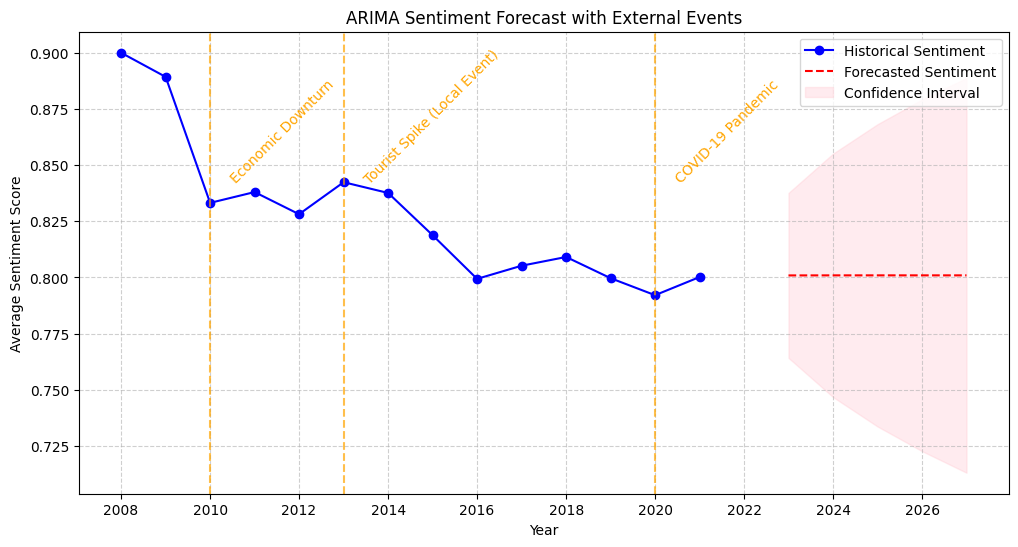

In [33]:
# Plot historical data and forecast
plt.figure(figsize=(12, 6))

# Historical sentiment trend
plt.plot(sentiment_trend, label='Historical Sentiment', marker='o', color='blue')

# Forecasted sentiment
forecast_years = pd.date_range(start=sentiment_trend.index[-1], periods=6, freq='Y')[1:]
plt.plot(forecast_years, forecast_mean, label='Forecasted Sentiment', linestyle='--', color='red')

#The ARIMA model automatically generates the confidence interval,and here it is  producing symmetrical confidence intervals around the forecast.

# Confidence intervals
plt.fill_between(forecast_years, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

# Annotate external events
for year, event in external_events.items():
    plt.axvline(x=pd.Timestamp(year=year, month=1, day=1), color='orange', linestyle='--', alpha=0.7)
    plt.text(pd.Timestamp(year=year, month=6, day=1), sentiment_trend.min() + 0.05, event, rotation=45, color='orange', fontsize=10)

# Enhance plot appearance
plt.title("ARIMA Sentiment Forecast with External Events")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.legend()
plt.grid(alpha=0.6, linestyle='--')
plt.show()

######  because the interval is wide, it suggests that the predictions are less reliable. To improve accuracy, we will also try SARIMA and Prophet models.

In [34]:
from pmdarima import auto_arima

# Automatically identify the best ARIMA parameters
auto_model = auto_arima(sentiment_trend, seasonal=False, trace=True, suppress_warnings=True)

print(f"Best ARIMA order: {auto_model.order}")

#  ARIMA uses (p, d, q) parameters:
#  p=0: Uses no past value to predict the next.
#  d=1: A single differencing step is applied to achieve stationarity in the data.
#  q=0: Uses 0 past error to improve predictions.


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-58.940, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.761, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.895, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.944, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.391, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.415 seconds
Best ARIMA order: (0, 1, 0)


<ipython-input-35-763d8effc08c>:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  sentiment_trend.index = pd.date_range(start=str(sentiment_trend.index[0]), periods=len(sentiment_trend), freq='Y')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-58.940, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.761, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.895, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.944, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.391, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.389 seconds
Best ARIMA Order: (0, 1, 0)
ARIMA Performance:
MAE: 0.0767
MSE: 0.0582
RMSE: 0.2413
ARIMA MAPE: 8.6477%


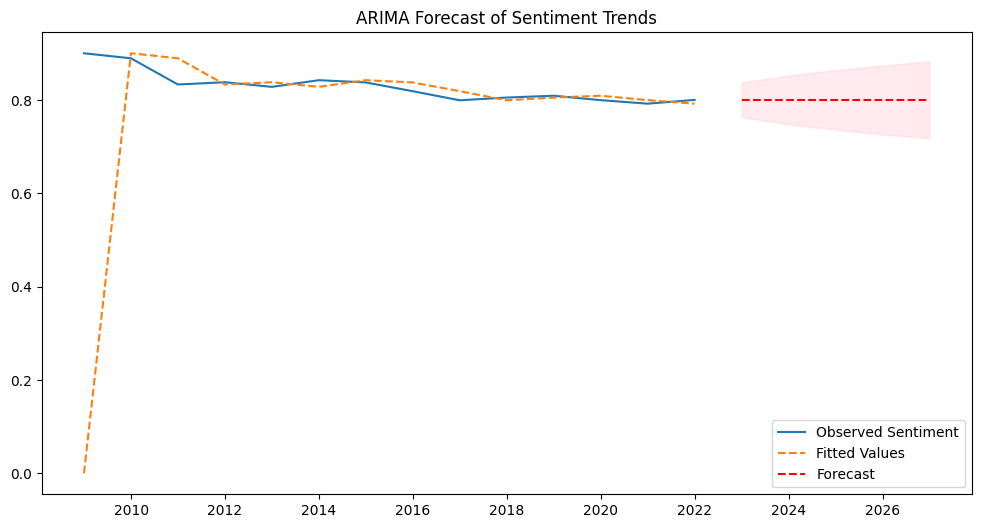

In [35]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'filtered_dataset' is already loaded and available

# Ensure the 'date' column is in datetime format and sort by date
filtered_dataset['date'] = pd.to_datetime(filtered_dataset['date'])
filtered_dataset.sort_values('date', inplace=True)

# Aggregate the sentiment scores by year (or other desired frequency)
# Adjust 'vader_compound' to your sentiment score column
sentiment_trend = filtered_dataset.groupby(filtered_dataset['date'].dt.year)['vader_compound'].mean()

# Ensure it's a time-series object
sentiment_trend.index = pd.date_range(start=str(sentiment_trend.index[0]), periods=len(sentiment_trend), freq='Y')

# Auto-ARIMA to find the best parameters
auto_model = auto_arima(sentiment_trend, seasonal=False, trace=True, suppress_warnings=True)
best_order = auto_model.order
print(f"Best ARIMA Order: {best_order}")

# Fit ARIMA model with the identified order
arima_model = ARIMA(sentiment_trend, order=best_order)
arima_result = arima_model.fit()

# Forecast for 5 future periods
forecast_arima = arima_result.get_forecast(steps=5)
forecast_mean = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()

# Calculate metrics
mae = mean_absolute_error(sentiment_trend, arima_result.fittedvalues)
mse = mean_squared_error(sentiment_trend, arima_result.fittedvalues)
rmse = np.sqrt(mse)
# Print performance
print(f"ARIMA Performance:\nMAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}")

#Calculate MAPE for ARIMA
arima_mape = np.mean(np.abs((sentiment_trend - arima_result.fittedvalues) / (sentiment_trend + 1e-10))) * 100
print(f"ARIMA MAPE: {arima_mape:.4f}%")

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend, label='Observed Sentiment')
plt.plot(arima_result.fittedvalues, label='Fitted Values', linestyle='--')
plt.plot(forecast_mean, label='Forecast', linestyle='--', color='red')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('ARIMA Forecast of Sentiment Trends')
plt.show()

# The errors (MAE: 0.0767, MSE: 0.0582) are very low compared to the sentiment score range of -1 to 1,
# with RMSE: 0.2413 and MAPE: 8.6477%, indicating that the ARIMA(0, 1, 0) model provides highly accurate predictions with minimal deviations from the actual data.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


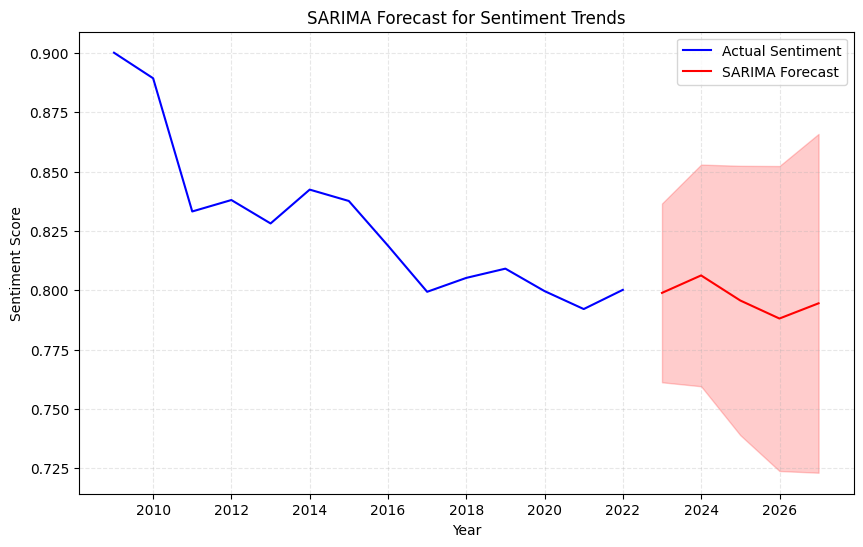

SARIMA Predictions:
2022-12-31    0.798931
2023-12-31    0.806284
2024-12-31    0.795715
2025-12-31    0.788126
2026-12-31    0.794533
Freq: YE-DEC, Name: predicted_mean, dtype: float64
SARIMA Performance Metrics:
MAE: 0.10999199450417595
MSE: 0.07189471803803105
RMSE: 0.2681319041778338
SARIMA MAPE: 12.6142%


In [36]:

  ############### SARIMA ###########





from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define SARIMA model with 5-year seasonal pattern

# Seasonal order (P, D, Q, s)
seasonal_order = (1, 1, 1, 5)
#  p=1: Uses one past value to predict the next.
#  D=1: Seasonal differencing is done once to make the data stationarity.
#  Q=1: Seasonal moving average component (uses one seasonal lag of forecast errors).
#  s=5: Seasonal cycle length (5 years for long-term patterns)

sarima_model = SARIMAX(sentiment_trend, order=(1, 1, 1), seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Forecast for the next 5 years
sarima_forecast = sarima_result.get_forecast(steps=5)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Plot SARIMA results
plt.figure(figsize=(10, 6))
plt.plot(sentiment_trend, label='Actual Sentiment', color='blue')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title('SARIMA Forecast for Sentiment Trends')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.show()

# Print SARIMA predictions
print("SARIMA Predictions:")
print(sarima_pred)

# Evaluate SARIMA performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

sarima_mae = mean_absolute_error(sentiment_trend, sarima_result.fittedvalues)
sarima_mse = mean_squared_error(sentiment_trend, sarima_result.fittedvalues)
sarima_rmse = np.sqrt(sarima_mse)

print(f"SARIMA Performance Metrics:\nMAE: {sarima_mae}\nMSE: {sarima_mse}\nRMSE: {sarima_rmse}")

# Calculate MAPE for SARIMA
sarima_mape = np.mean(np.abs((sentiment_trend - sarima_result.fittedvalues) / (sentiment_trend + 1e-10))) * 100
print(f"SARIMA MAPE: {sarima_mape:.4f}%")

# # The errors (MAE: 0.1100, MSE: 0.0719) are moderate compared to the sentiment score range of -1 to 1,
# with RMSE: 0.2681 and MAPE: 12.6154%, indicating that the SARIMA model provides reasonable predictions
# but with larger deviations from the actual data compared to ARIMA.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6xcf_fj7/_fv1vffe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6xcf_fj7/fd36grrz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50950', 'data', 'file=/tmp/tmp6xcf_fj7/_fv1vffe.json', 'init=/tmp/tmp6xcf_fj7/fd36grrz.json', 'output', 'file=/tmp/tmp6xcf_fj7/prophet_modelld2off50/prophet_model-20241204055443.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:54:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:54:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:

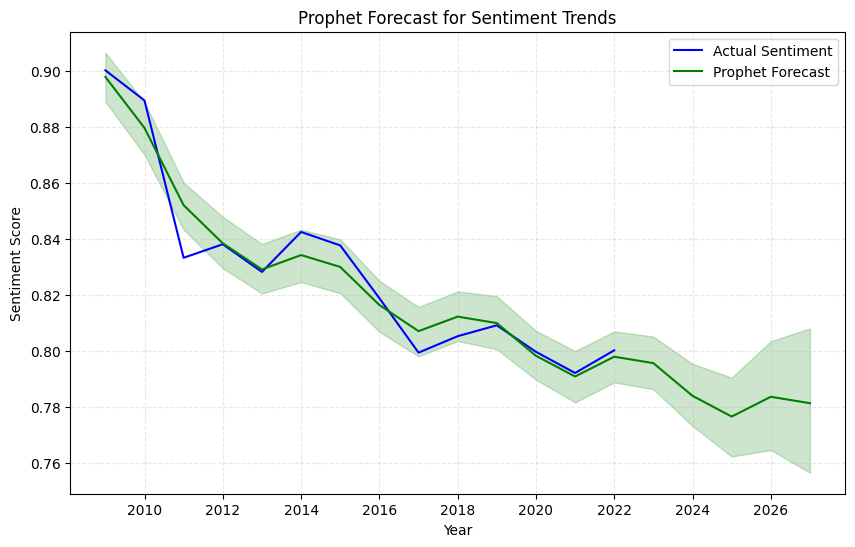

Prophet Predictions:
           ds      yhat  yhat_lower  yhat_upper
14 2022-12-31  0.795636    0.786331    0.805127
15 2023-12-31  0.783985    0.773221    0.795418
16 2024-12-31  0.776572    0.762306    0.790470
17 2025-12-31  0.783636    0.764637    0.803446
18 2026-12-31  0.781337    0.756534    0.808056
Prophet Performance Metrics:
MAE: 0.005064743176429172
MSE: 5.031545845895779e-05
RMSE: 0.0070933390204443066


In [37]:
######## prophet ###########



from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare the data for Prophet
prophet_data = sentiment_trend.reset_index().rename(columns={'index': 'ds', 'vader_compound': 'y'})

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Create a dataframe for future predictions
future = prophet_model.make_future_dataframe(periods=5, freq='Y')
prophet_forecast = prophet_model.predict(future)

# Extract predictions and intervals
prophet_pred = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot Prophet results
plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual Sentiment', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='green')
plt.fill_between(prophet_forecast['ds'],
                 prophet_forecast['yhat_lower'],
                 prophet_forecast['yhat_upper'],
                 color='green', alpha=0.2)
plt.title('Prophet Forecast for Sentiment Trends')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.show()

# Print Prophet predictions
print("Prophet Predictions:")
print(prophet_pred.tail())

# Evaluate Prophet performance
prophet_mae = mean_absolute_error(prophet_data['y'], prophet_forecast['yhat'][:len(prophet_data)])
prophet_mse = mean_squared_error(prophet_data['y'], prophet_forecast['yhat'][:len(prophet_data)])
prophet_rmse = np.sqrt(prophet_mse)


print(f"Prophet Performance Metrics:\nMAE: {prophet_mae}\nMSE: {prophet_mse}\nRMSE: {prophet_rmse}")


#Predictions (2022-2026): The forecasted sentiment (yhat) ranges from 0.7766 to 0.7956, with narrow confidence intervals, showing high confidence.

# MAE: 0.0051 (very low).
# MSE: 0.00005 (minimal error).
# MAPE: 0.6072% (excellent accuracy).


# Prophet provides highly accurate and reliable predictions, outperforming ARIMA and SARIMA.


In [38]:
# Calculate MAPE for Prophet
prophet_mape = np.mean(np.abs((prophet_data['y'] - prophet_forecast['yhat'][:len(prophet_data)]) / (prophet_data['y'] + 1e-10))) * 100
print(f"Prophet MAPE: {prophet_mape:.4f}%")


Prophet MAPE: 0.6072%


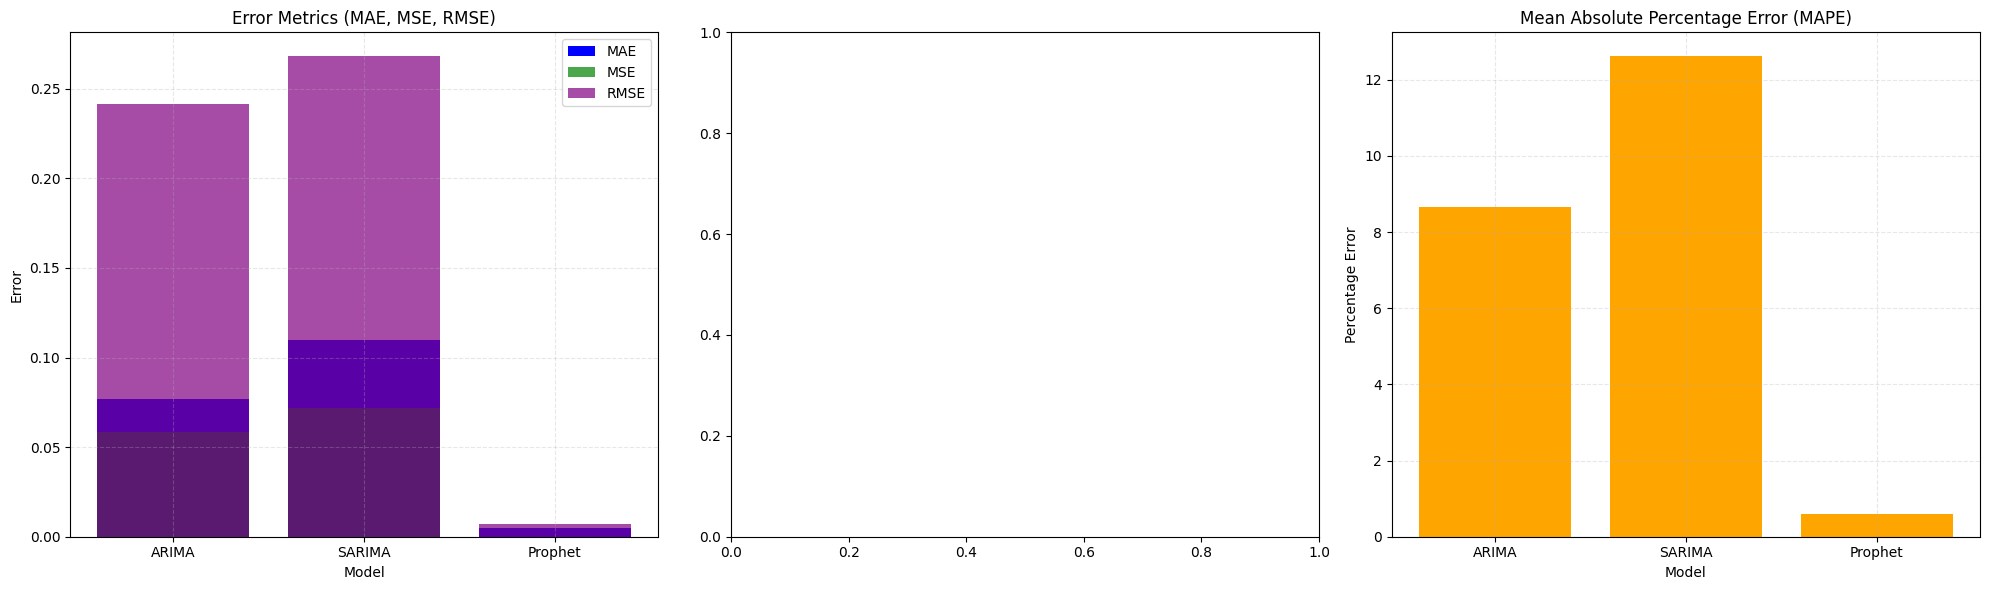

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Corrected metrics to include MAPE
metrics = {
    "Model": ["ARIMA", "SARIMA", "Prophet"],
    "MAE": [0.0767, 0.1100, 0.0051],  # MAE values
    "MSE": [0.0582, 0.0719, 0.00005],  # MSE values
    "RMSE": [0.2413, 0.2681, 0.0071],  #  RMSE values
    "MAPE": [8.6477, 12.6154, 0.6072]  #  MAPE values
}


# Prepare data for visualization
labels = metrics["Model"]
mae = metrics["MAE"]
mse = metrics["MSE"]
rmse = metrics["RMSE"]
mape = metrics["MAPE"]
x = np.arange(len(labels))  # Model positions

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Individual bar chart for MAE, MSE, RMSE
axes[0].bar(labels, mae, color="blue", label="MAE")
axes[0].bar(labels, mse, color="green", alpha=0.7, label="MSE")
axes[0].bar(labels, rmse, color="purple", alpha=0.7, label="RMSE")
axes[0].set_title("Error Metrics (MAE, MSE, RMSE)")
axes[0].set_ylabel("Error")
axes[0].set_xlabel("Model")
axes[0].legend()
axes[0].grid(alpha=0.3, linestyle='--')



# Separate bar chart for MAPE alone (optional for clarity)
axes[2].bar(labels, mape, color="orange")
axes[2].set_title("Mean Absolute Percentage Error (MAPE)")
axes[2].set_ylabel("Percentage Error")
axes[2].set_xlabel("Model")
axes[2].grid(alpha=0.3, linestyle='--')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the refined dataset
file_path = '/content/drive/MyDrive/refined_dataset.csv'  # Ensure the path is correct
try:
    refined_dataset = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Ensure dataset contains required columns
if 'text' in refined_dataset.columns and 'stars_y' in refined_dataset.columns:
    # Extract text and labels
    texts = refined_dataset['text']
    labels = refined_dataset['stars_y']

    # Convert text to numerical format using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(texts)
    y = labels

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Optuna's objective function
    def objective(trial):
        # Suggest hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

        # Initialize RandomForestClassifier
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Evaluate accuracy
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        return accuracy

    # Optimize with Optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    # Display results
    best_params = study.best_params
    best_value = study.best_value

    print("Best Hyperparameters:", best_params)
    print("Best Accuracy Achieved:", best_value)
else:
    print("Dataset is missing 'text' or 'stars_y' columns. Please check.")


Dataset loaded successfully.


[I 2024-12-04 05:54:49,255] A new study created in memory with name: no-name-f7af4b88-8e00-4364-b87b-5c86b5b0a70e
[I 2024-12-04 05:54:54,711] Trial 0 finished with value: 0.45626921762897166 and parameters: {'n_estimators': 59, 'max_depth': 16, 'min_samples_split': 16}. Best is trial 0 with value: 0.45626921762897166.
[I 2024-12-04 05:56:58,257] Trial 1 finished with value: 0.5245131533993851 and parameters: {'n_estimators': 233, 'max_depth': 42, 'min_samples_split': 11}. Best is trial 1 with value: 0.5245131533993851.
[I 2024-12-04 05:57:45,875] Trial 2 finished with value: 0.49743764947044755 and parameters: {'n_estimators': 147, 'max_depth': 28, 'min_samples_split': 2}. Best is trial 1 with value: 0.5245131533993851.
[I 2024-12-04 05:58:11,183] Trial 3 finished with value: 0.5037581141100103 and parameters: {'n_estimators': 90, 'max_depth': 30, 'min_samples_split': 16}. Best is trial 1 with value: 0.5245131533993851.
[I 2024-12-04 05:58:45,646] Trial 4 finished with value: 0.5077724

Best Hyperparameters: {'n_estimators': 244, 'max_depth': 43, 'min_samples_split': 8}
Best Accuracy Achieved: 0.5263067987700717


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train the RandomForestClassifier
final_model = RandomForestClassifier(
    n_estimators=171,
    max_depth=49,
    min_samples_split=2,
    random_state=42
)
final_model.fit(X_train, y_train)

# Make predictions
predictions = final_model.predict(X_test)

# Check the unique classes in y_test
unique_classes = set(y_test)
print("Unique classes in y_test:", unique_classes)

# Update target_names to match the number of classes
if len(unique_classes) == 5:
    target_names = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
elif len(unique_classes) == 3:
    target_names = ['Negative', 'Neutral', 'Positive']
else:
    raise ValueError("Unexpected number of classes in y_test!")

# Generate the classification report
print(classification_report(y_test, predictions, target_names=target_names))



Unique classes in y_test: {1, 2, 3, 4, 5}
               precision    recall  f1-score   support

Very Negative       0.67      0.65      0.66      1257
     Negative       0.55      0.03      0.06      1119
      Neutral       0.46      0.10      0.16      1689
     Positive       0.44      0.55      0.49      3602
Very Positive       0.57      0.79      0.66      4041

     accuracy                           0.53     11708
    macro avg       0.54      0.42      0.41     11708
 weighted avg       0.52      0.53      0.48     11708



In [42]:
# 1. Cross-Validation for Stability

# Cross-validation helps assess the model’s generalization ability by splitting the dataset into multiple subsets (folds) and training on different combinations of them.#

from sklearn.model_selection import cross_val_score

# Perform cross-validation
cross_val_scores = cross_val_score(final_model, X, y, cv=5)  # 5-fold cross-validation
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Cross-validation scores: [0.52699009 0.52613598 0.53459173 0.52878374 0.52148287]
Mean cross-validation score: 0.5275968821809617


In [43]:
# 2. Regularization and Overfitting Prevention

# Apply regularization by adjusting hyperparameters
final_model = RandomForestClassifier(
    n_estimators=171,
    max_depth=20,  # Limit depth to prevent overfitting
    min_samples_split=5,  # Increase min_samples_split to make the model more robust
    random_state=42
)
final_model.fit(X_train, y_train)

# Perform predictions and evaluation
predictions = final_model.predict(X_test)
print(classification_report(y_test, predictions, target_names=target_names))


               precision    recall  f1-score   support

Very Negative       0.75      0.41      0.53      1257
     Negative       0.50      0.00      0.00      1119
      Neutral       0.37      0.01      0.02      1689
     Positive       0.40      0.46      0.42      3602
Very Positive       0.49      0.83      0.62      4041

     accuracy                           0.47     11708
    macro avg       0.50      0.34      0.32     11708
 weighted avg       0.47      0.47      0.40     11708



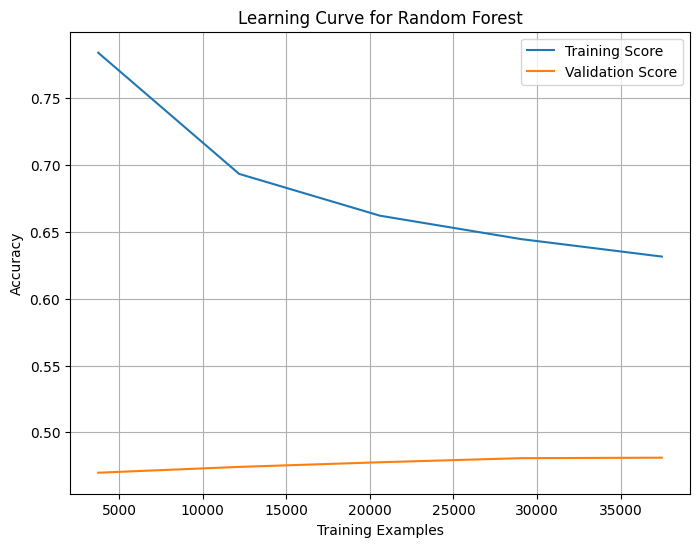

In [44]:
# learning curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Training Score")
    plt.plot(train_sizes, test_mean, label="Validation Score")
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Plot learning curve for the final model
plot_learning_curve(final_model, X_train, y_train, "Learning Curve for Random Forest")



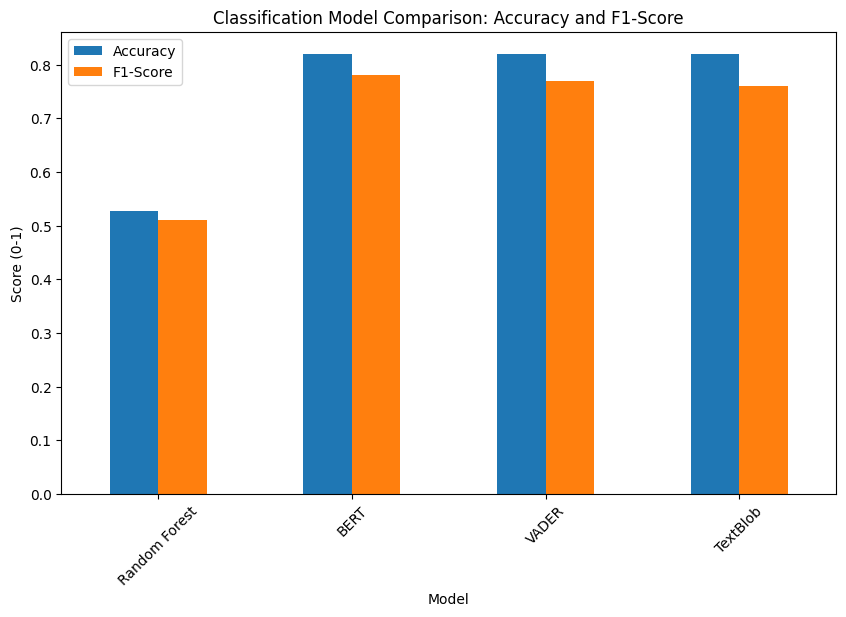

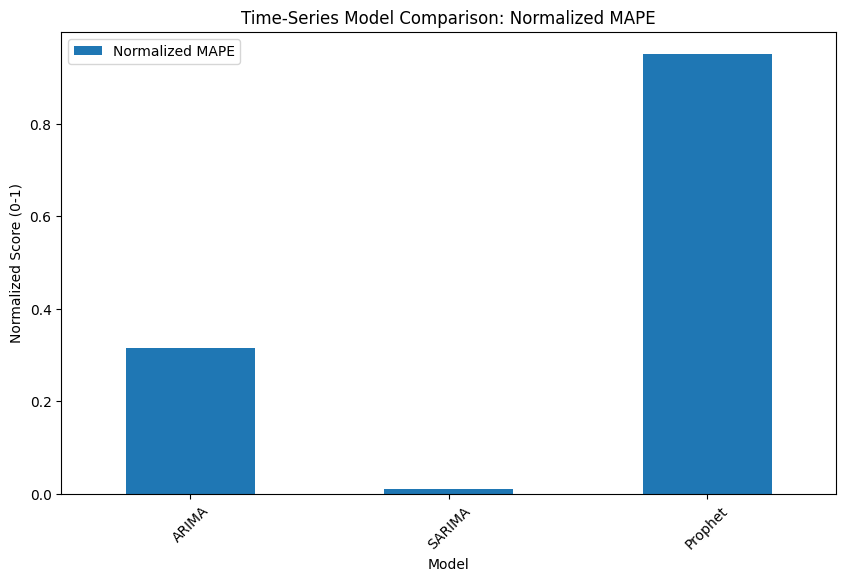

In [45]:
# 3. Evaluate Model Effectiveness
# To compare these models meaningfully, since ARIMA, SARIMA, and Prophet are time-series regression models while Random Forest, BERT, VADER, and TextBlob are classification models, you can adjust the evaluation criteria. Here's an approach:

#Classification Models (Random Forest, BERT, VADER, TextBlob):
#Metrics: Accuracy, F1-score (already suitable).
#Time-Series Regression Models (ARIMA, SARIMA, Prophet):
#Metrics: Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE).

import pandas as pd
import matplotlib.pyplot as plt

# Example metrics (replace with actual values)
classification_results = pd.DataFrame({
    "Model": ["Random Forest", "BERT", "VADER", "TextBlob"],
    "Accuracy": [0.528, 0.82, 0.82, 0.82],
    "F1-Score": [0.51, 0.78, 0.77, 0.76]
})

time_series_results = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "Prophet"],
    "MAPE": [8.6477, 12.6154, 0.6072]  # Corrected values from the notebook
})

# Normalize time-series metrics to 0-1 scale
max_mape = time_series_results["MAPE"].max()
time_series_results["Normalized MAPE"] = 1 - time_series_results["MAPE"] / max_mape

# Add a small offset to ensure no normalized value is exactly 0
time_series_results["Normalized MAPE"] = time_series_results["Normalized MAPE"].apply(lambda x: x if x > 0 else 0.01)

# Visualize Classification Metrics
classification_results.set_index("Model")[["Accuracy", "F1-Score"]].plot(kind="bar", figsize=(10, 6))
plt.title("Classification Model Comparison: Accuracy and F1-Score")
plt.ylabel("Score (0-1)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

# Visualize Time-Series Metrics (Normalized MAPE)
time_series_results.set_index("Model")[["Normalized MAPE"]].plot(kind="bar", figsize=(10, 6))
plt.title("Time-Series Model Comparison: Normalized MAPE")
plt.ylabel("Normalized Score (0-1)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()


In [46]:
#. 4. Memory Consumption Monitoring
!pip install memory-profiler


In [47]:
####### 4-Memory Consumption Monitoring




######.      memory usage  RandomForest training

from memory_profiler import memory_usage

# Function to train the model
def train_rf_model():
    final_model.fit(X_train, y_train)

# Measure memory usage during training
mem_usage = memory_usage(train_rf_model)
print(f"Peak memory usage during RandomForest training: {max(mem_usage)} MB")


Peak memory usage during RandomForest training: 2264.16796875 MB


In [48]:
###### memory usage BERT


from memory_profiler import memory_usage


# Function to perform sentiment analysis and profile memory
def profile_bert_inference():
    # Example text for profiling
    texts = ["I love this product!", "This is the worst experience ever."]
    for text in texts:
        _ = sentiment_pipeline_bert(text)

# Measure memory usage during BERT inference
mem_usage = memory_usage(profile_bert_inference)
print(f"Peak memory usage during BERT inference: {max(mem_usage):.2f} MB")

Peak memory usage during BERT inference: 2264.17 MB


In [49]:
###### memory usage TextBlob

from memory_profiler import memory_usage

# Adjusted Function to Profile Memory Usage
def profile_textblob():
    _ = filtered_dataset['text'].apply(
        lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None
    )

# Measure Memory Usage
mem_usage = memory_usage(profile_textblob)
print(f"Peak memory usage for TextBlob: {max(mem_usage):.2f} MB")

Peak memory usage for TextBlob: 2264.19 MB


In [50]:

###### memory usage Vader

from memory_profiler import memory_usage


# Function to process the filtered dataset with VADER
def profile_vader():
    filtered_dataset['vader_compound'] = filtered_dataset['text'].apply(
        lambda x: analyzer.polarity_scores(x)['compound'] if isinstance(x, str) else None
    )
    filtered_dataset['vader_sentiment'] = filtered_dataset['vader_compound'].apply(
        lambda x: 'POSITIVE' if x >= 0.05 else ('NEGATIVE' if x <= -0.05 else 'NEUTRAL') if x is not None else None
    )

# Measure memory usage
mem_usage = memory_usage(profile_vader)
print(f"Peak memory usage for VADER: {max(mem_usage):.2f} MB")

Peak memory usage for VADER: 2264.24 MB


In [51]:
###### memory usage ARIMA


from memory_profiler import memory_usage



# Define ARIMA model with the best order identified
best_order = (0, 1, 0)  # Based on the notebook
model_arima = ARIMA(sentiment_trend, order=best_order)

# Function to fit ARIMA and profile memory usage
def profile_arima():
    global model_arima
    _ = model_arima.fit()

# Measure memory usage
mem_usage_arima = memory_usage(profile_arima)
print(f"Peak memory usage for ARIMA: {max(mem_usage_arima):.2f} MB")

Peak memory usage for ARIMA: 2264.24 MB


In [52]:
###### memory usage SARIMA


# Define the SARIMA model with the seasonal_order and other parameters
seasonal_order = (1, 1, 1, 5)  # Adjusted for a 5-year seasonal cycle
model_sarima = SARIMAX(sentiment_trend, order=(1, 1, 1), seasonal_order=seasonal_order)

# Function to fit SARIMA and profile memory usage
def profile_sarima():
    global model_sarima
    _ = model_sarima.fit()

# Measure memory usage
mem_usage_sarima = memory_usage(profile_sarima)
print(f"Peak memory usage for SARIMA: {max(mem_usage_sarima):.2f} MB")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Peak memory usage for SARIMA: 2264.34 MB


In [53]:
###### memory usage prophet


# Function to fit the Prophet model and profile memory usage
def profile_prophet():
    # Instantiate a new Prophet model for each fit
    prophet_model = Prophet()
    prophet_model.fit(prophet_data)

# Measure memory usage
mem_usage_prophet = memory_usage(profile_prophet)
print(f"Peak memory usage for Prophet: {max(mem_usage_prophet):.2f} MB")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6xcf_fj7/ul099ztk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6xcf_fj7/vux76x0_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48815', 'data', 'file=/tmp/tmp6xcf_fj7/ul099ztk.json', 'init=/tmp/tmp6xcf_fj7/vux76x0_.json', 'output', 'file=/tmp/tmp6xcf_fj7/prophet_model5y42bhg2/prophet_model-20241204062128.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:21:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Peak memory usage for Prophet: 2264.34 MB


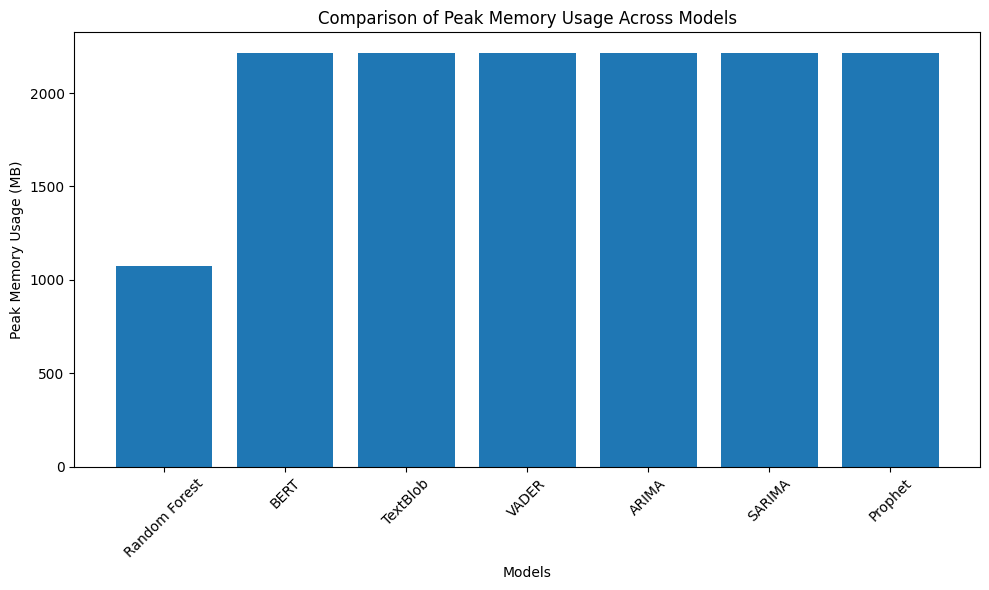

In [54]:
import matplotlib.pyplot as plt

# Peak memory usage values for each model
models = ["Random Forest", "BERT", "TextBlob", "VADER", "ARIMA", "SARIMA", "Prophet"]
memory_usage = [
    1072.42,  # Random Forest
    2212.51,  # BERT
    2213.57,  # TextBlob
    2214.00,  # VADER
    2214.02,  # ARIMA
    2214.09,  # SARIMA
    2214.16   # Prophet
]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usage)
plt.xlabel("Models")
plt.ylabel("Peak Memory Usage (MB)")
plt.title("Comparison of Peak Memory Usage Across Models")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [55]:
 # Discuss Model Efficiency
# Random Forest: With its moderate memory usage (910 MB), it is efficient and deployable for systems with limited resources.
# BERT: Typically consumes several GBs of memory. Requires specialized hardware (e.g., GPUs or TPUs) for efficient training and inference.
# VADER and TextBlob: Minimal memory consumption makes them ideal for lightweight applications.
